# 1. Установка и импорт

В этом задании вам предстоит выполнить полный EDA анализ
и ответить на вопросы по результатам анализа.

Для выполнения задания:
1. Изучите данные и выполните весь пайплайн EDA
2. Ответьте на вопросы в конце файла
3. Заполните ответы в словаре answers

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import missingno as msno
import seaborn as sns

# 2. Загрузка данных

Данные о страховых случаях

Описание признаков:
- age: возраст клиента
- bmi: индекс массы тела
- children: количество детей/иждивенцев
- charges: стоимость страховки
- smoker: курит ли клиент (yes/no)
- region: регион проживания (southwest, southeast, northwest, northeast)
- insurance_claim: была ли подана страховка (0 - нет, 1 - да)

In [2]:
np.random.seed(2024)
n_samples = 1000

# Создаем DataFrame
df_insurance = pd.DataFrame({
    'age': np.random.normal(40, 15, n_samples).clip(18, 80).astype(int),
    'bmi': np.random.normal(28, 6, n_samples).clip(15, 50),
    'children': np.random.poisson(1.5, n_samples).clip(0, 5),
    'charges': np.random.exponential(15000, n_samples) + 1000,
    'smoker': np.random.choice(['yes', 'no'], n_samples, p=[0.2, 0.8]),
    'region': np.random.choice(['southwest', 'southeast', 'northwest', 'northeast'],
                               n_samples, p=[0.25, 0.3, 0.25, 0.2]),
    'insurance_claim': np.random.binomial(1, 0.3, n_samples)
})
df_insurance

,age,bmi,children,charges,smoker,region,insurance_claim
0,65,36.349066,0,12905.961727,no,northeast,1
1,51,28.934381,1,2583.734319,no,southeast,0
2,36,25.402012,3,21576.610720,yes,northeast,0
3,37,23.954296,2,5739.464506,no,northeast,1
4,53,29.530733,1,15400.573233,no,southeast,0
...,...,...,...,...,...,...,...
995,43,20.417764,1,14233.321643,yes,northwest,0
996,26,29.293815,1,7536.267804,no,southwest,0
997,25,16.977591,1,38838.663169,no,southwest,1
998,38,18.795050,2,23514.901627,no,northwest,0


In [3]:
# Добавляем реалистичные зависимости
df_insurance.loc[df_insurance['smoker'] == 'yes', 'charges'] *= 2.5
df_insurance.loc[df_insurance['age'] > 60, 'charges'] *= 1.3
df_insurance.loc[df_insurance['bmi'] > 35, 'charges'] *= 1.2

In [4]:
# Добавляем пропуски (реалистичный паттерн)
# У курильщиков реже заполнен BMI
smoker_mask = df_insurance['smoker'] == 'yes'
df_insurance.loc[smoker_mask & (np.random.rand(n_samples) < 0.15), 'bmi'] = np.nan

# У пожилых реже заполнены дети
age_mask = df_insurance['age'] > 65
df_insurance.loc[age_mask & (np.random.rand(n_samples) < 0.1), 'children'] = np.nan

# В северо-восточном регионе пропуски в charges
region_mask = df_insurance['region'] == 'northeast'
df_insurance.loc[region_mask & (np.random.rand(n_samples) < 0.08), 'charges'] = np.nan

# Добавляем выбросы
# Выбросы в charges
outlier_indices = np.random.choice(n_samples, 15, replace=False)
df_insurance.loc[outlier_indices, 'charges'] *= 4

# Выбросы в bmi
outlier_indices_bmi = np.random.choice(n_samples, 10, replace=False)
df_insurance.loc[outlier_indices_bmi, 'bmi'] = df_insurance.loc[outlier_indices_bmi, 'bmi'] * 1.8

Задание 1: вывести на экран "шапку", размер датафрейма, количество признаков, представленные типы данных и статистику числовых признаков

In [15]:
print(df_insurance.head())
print(f'\nРазмер датафрейма:\nСтроки - {df_insurance.shape[0]}, Столбцы - {df_insurance.shape[1]}')
print(f'\nКоличество признаков: {len(df_insurance.columns)}')
print(f'\nТипы данных:\n{df_insurance.dtypes}')
print(f'\nСтатистика числовых признаков:\n{df_insurance[['age', 'bmi', 'children', 'charges', 'insurance_claim']].describe()}')

   age        bmi  children       charges smoker     region  insurance_claim
0   65  36.349066       0.0           NaN     no  northeast                1
1   51  28.934381       1.0   2583.734319     no  southeast                0
2   36  25.402012       3.0  53941.526800    yes  northeast                0
3   37  23.954296       2.0   5739.464506     no  northeast                1
4   53  29.530733       1.0  15400.573233     no  southeast                0

Размер датафрейма:
Строки - 1000, Столбцы - 7

Количество признаков: 7

Типы данных:
age                  int64
bmi                float64
children           float64
charges            float64
smoker              object
region              object
insurance_claim      int64
dtype: object

Статистика числовых признаков:
               age         bmi    children        charges  insurance_claim
count  1000.000000  970.000000  995.000000     983.000000      1000.000000
mean     40.319000   27.990417    1.487437   21395.192439         0

# 3. Анализ пропусков с использованием msno, dropna, isnull

Задание 2: провести анализ по плану

In [40]:
df_insurance.columns

Index(['age', 'bmi', 'children', 'charges', 'smoker', 'region',
       'insurance_claim'],
      dtype='object')

Количество пропусков по признакам:

age : нет пропусков
bmi : 30 пропусков (3.0%)
children : 5 пропусков (0.5%)
charges : 17 пропусков (1.7%)
smoker : нет пропусков
region : нет пропусков
insurance_claim : нет пропусков

Удаление всех строк с NaN: (948, 7)
Удаление всех столбцов с NaN: (1000, 4)
Удаление строк с количеством NaN не менее 7: (948, 7)


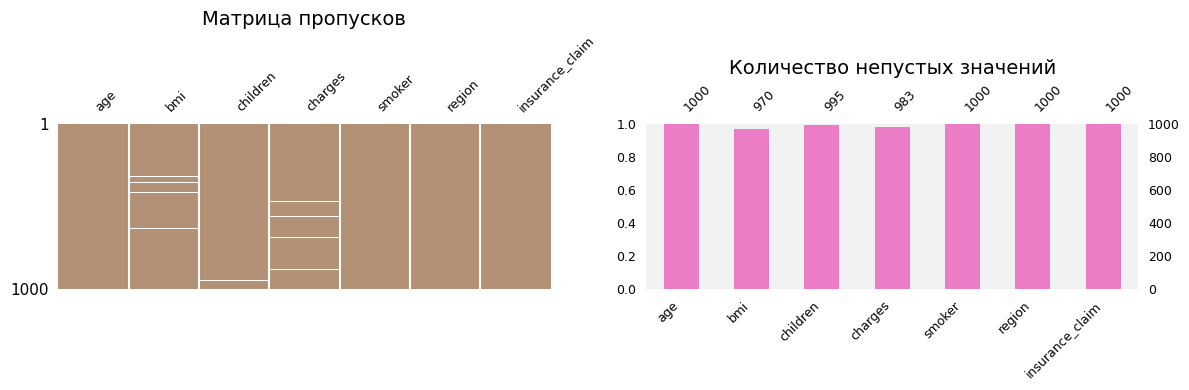

In [51]:
print('Количество пропусков по признакам:\n')
for col in df_insurance.columns:
  if df_insurance[col].isnull().sum()==0:
    print(f'{col} : нет пропусков')
  else:
    print(f'{col} : {df_insurance[col].isnull().sum()} пропусков ({round((df_insurance[col].isnull().sum()/len(df_insurance[col]))*100, 2)}%)')

print(f'\nУдаление всех строк с NaN: {df_insurance.dropna().shape}')
print(f'Удаление всех столбцов с NaN: {df_insurance.dropna(axis=1).shape}')
print(f'Удаление строк с количеством NaN не менее 7: {df_insurance.dropna(thresh=7).shape}')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

msno.matrix(
    df_insurance,
    sparkline=False,
    fontsize=9,
    color=(0.7, 0.57, 0.47),
    ax=axes[0]
)
axes[0].set_title("Матрица пропусков", fontsize=14)

msno.bar(
    df_insurance,
    fontsize=9,
    color=(0.92, 0.49, 0.78),
    ax=axes[1]
)
axes[1].set_title("Количество непустых значений", fontsize=14)
axes[1].set_facecolor("#F2F2F2")

plt.tight_layout()
plt.show()


# 4. Визуализация с boxplot и iqr

Задание 3: визуализируйте числовые признаки с boxplot и посчитывайте выбросы с iqr

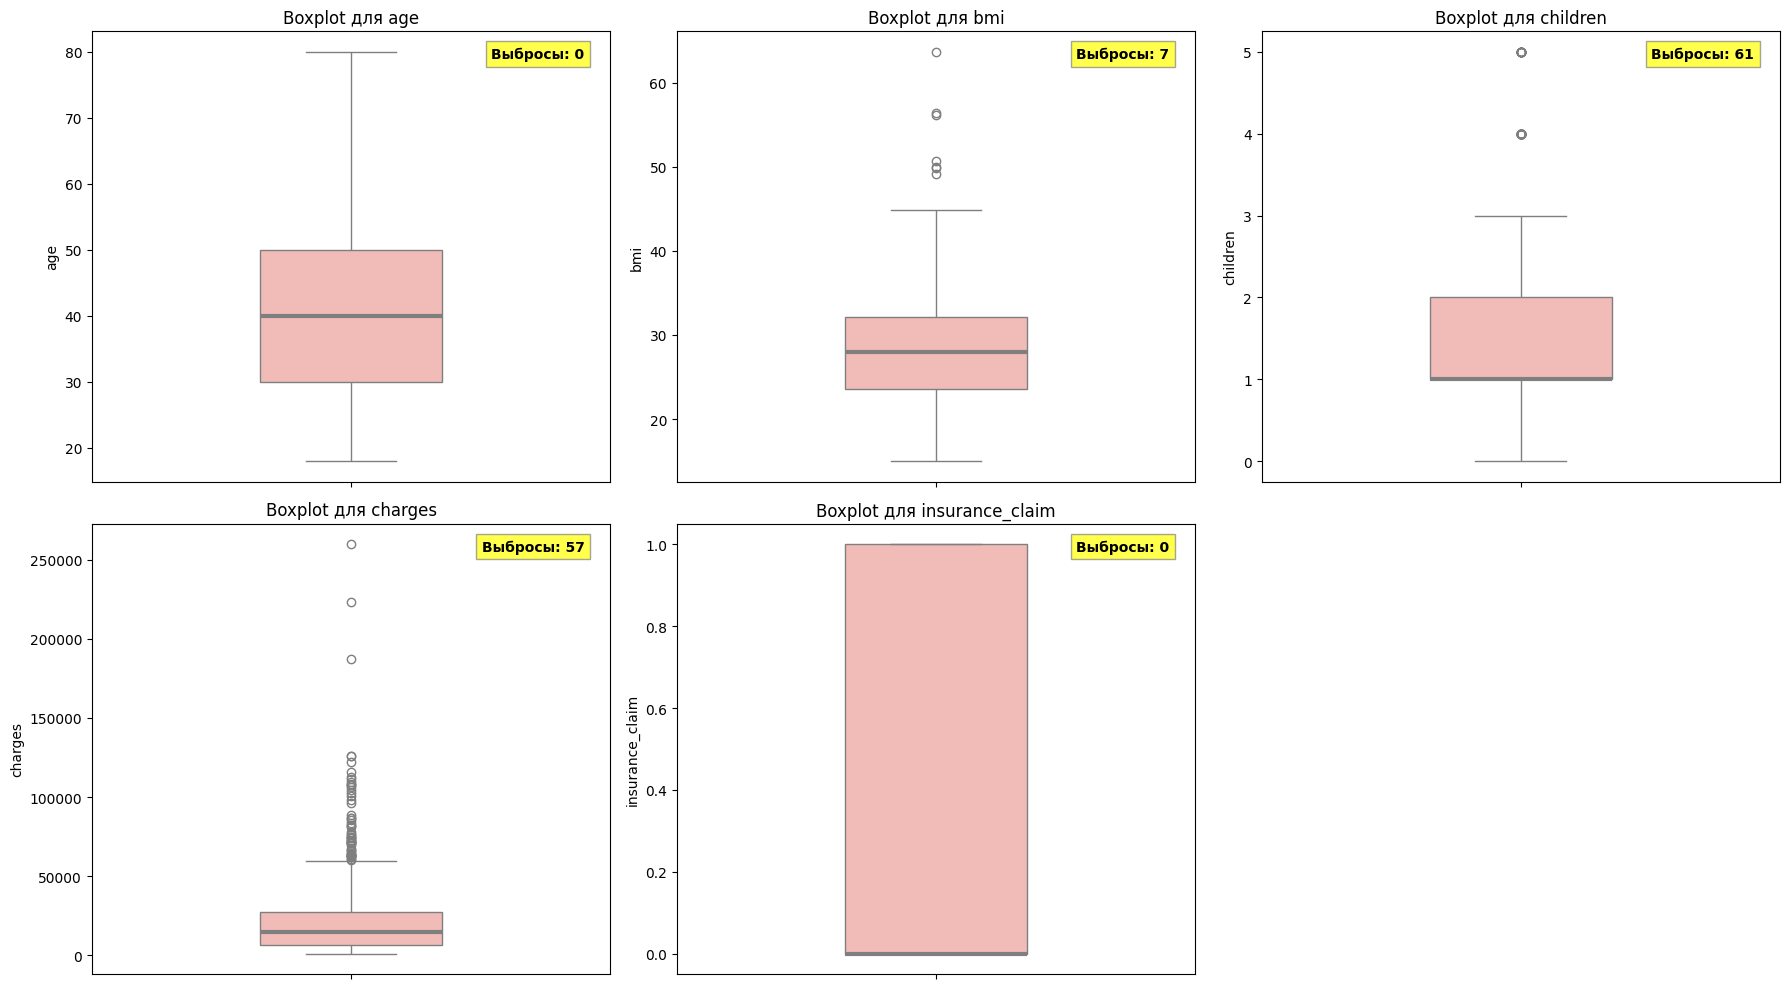


Описание распределений (IQR-анализ):

age:
  Q1: 30.00, Q3: 50.00, IQR: 20.00
  Границы: [0.00, 80.00]
  Выбросов: 0 (0.0%)

bmi:
  Q1: 23.57, Q3: 32.17, IQR: 8.60
  Границы: [10.68, 45.07]
  Выбросов: 7 (0.7%)

children:
  Q1: 1.00, Q3: 2.00, IQR: 1.00
  Границы: [-0.50, 3.50]
  Выбросов: 61 (6.1%)

charges:
  Q1: 6317.17, Q3: 27662.99, IQR: 21345.82
  Границы: [-25701.56, 59681.72]
  Выбросов: 57 (5.8%)

insurance_claim:
  Q1: 0.00, Q3: 1.00, IQR: 1.00
  Границы: [-1.50, 2.50]
  Выбросов: 0 (0.0%)



In [32]:
stats = {}

numeric_features = df_insurance.select_dtypes(include=['int64', 'float64']).columns
cols = 3
rows = (len(numeric_features) + cols - 1) // cols
plt.figure(figsize=(cols * 6, rows * 5))

for i, col in enumerate(numeric_features, 1):
    plt.subplot(rows, cols, i)

    data = df_insurance[col].dropna()

    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count = ((data < lower_bound) | (data > upper_bound)).sum()
    outliers_pct = outliers_count / len(data) * 100

    stats[col] = {
        "Q1": Q1,
        "Q3": Q3,
        "IQR": IQR,
        "lower": lower_bound,
        "upper": upper_bound,
        "outliers": outliers_count,
        "outliers_pct": outliers_pct
    }

    sns.boxplot(
        y=data,
        width=0.35,
        color=sns.color_palette("Pastel1")[0],
        medianprops={"linewidth": 3}
    )

    plt.text(
        0.95,
        0.95,
        f"Выбросы: {outliers_count}",
        fontweight='bold',
        ha='right',
        va='center',
        transform=plt.gca().transAxes,
        fontsize=10,
        bbox=dict(facecolor="yellow", alpha=0.7, edgecolor="gray")
    )

    plt.title(f"Boxplot для {col}")

plt.tight_layout()
plt.show()

print("\nОписание распределений (IQR-анализ):\n")

for col, s in stats.items():
    print(
        f"{col}:\n"
        f"  Q1: {s['Q1']:.2f}, Q3: {s['Q3']:.2f}, IQR: {s['IQR']:.2f}\n"
        f"  Границы: [{s['lower']:.2f}, {s['upper']:.2f}]\n"
        f"  Выбросов: {s['outliers']} ({s['outliers_pct']:.1f}%)\n"
    )

# 5. Анализ распределений и взаимосвязей

Задание 4.1: выполните визуализацию распределений для двух ключевых признаков: charges и bmi, а также постройте кореллограмму

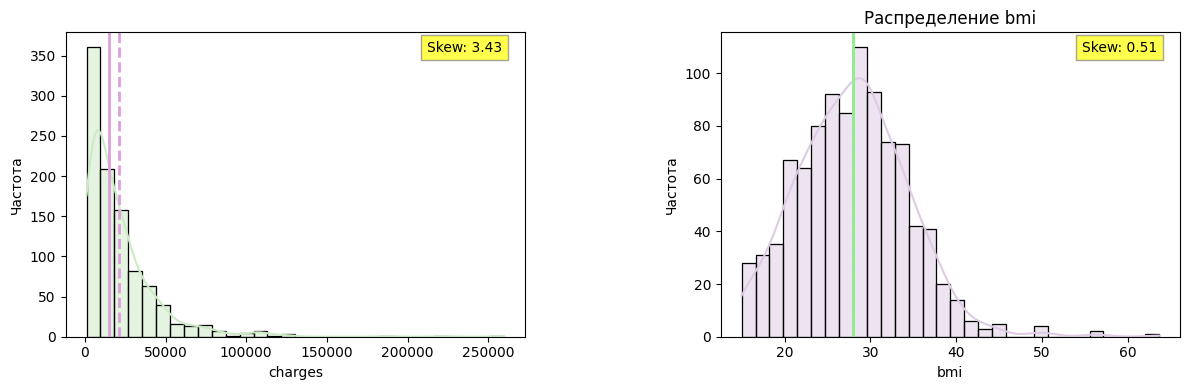


Корреляционная матрица:
                       age       bmi  children   charges  insurance_claim
age              1.000000  0.037241  0.013910  0.006119        -0.025864
bmi              0.037241  1.000000  0.030424  0.026661        -0.032390
children         0.013910  0.030424  1.000000 -0.038488        -0.029389
charges          0.006119  0.026661 -0.038488  1.000000        -0.029412
insurance_claim -0.025864 -0.032390 -0.029389 -0.029412         1.000000



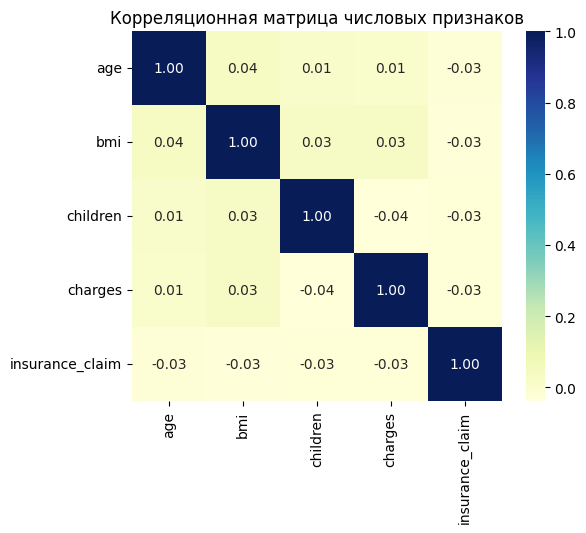

In [39]:
charges = df_insurance["charges"].dropna()
bmi = df_insurance["bmi"].dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(
    charges,
    bins=30,
    kde=True,
    color=sns.color_palette("Pastel1")[2],
    ax=axes[0]
)

axes[0].axvline(charges.mean(), linestyle="--", linewidth=2, label=f"Mean: {charges.mean():.1f}", c="#DDA0DD")
axes[0].axvline(charges.median(), linestyle="-", linewidth=2, label=f"Median: {charges.median():.1f}", c="#DDA0DD")

plt.text(
        0.95,
        0.95,
        f"Skew: {charges.skew():.2f}",
        ha='right',
        va='center',
        transform=axes[0].transAxes,
        fontsize=10,
        bbox=dict(facecolor="yellow", alpha=0.7, edgecolor="gray")
    )

plt.title("Распределение charges")
axes[0].set_ylabel("Частота")

sns.histplot(
    bmi,
    bins=30,
    kde=True,
    line_kws={"color": "#DDA0DD"},
    color=sns.color_palette("Pastel1")[3],
    ax=axes[1]
)

axes[1].axvline(bmi.mean(), linestyle="--", linewidth=2, label=f"Mean: {bmi.mean():.1f}", c="#90EE90")
axes[1].axvline(bmi.median(), linestyle="-", linewidth=2, label=f"Median: {bmi.median():.1f}", c="#90EE90")

plt.text(
        0.95,
        0.95,
        f"Skew: {bmi.skew():.2f}",
        ha='right',
        va='center',
        transform=axes[1].transAxes,
        fontsize=10,
        bbox=dict(facecolor="yellow", alpha=0.7, edgecolor="gray")
    )

plt.title("Распределение bmi")
axes[1].set_ylabel("Частота")


plt.tight_layout()
plt.show()


numeric_df = df_insurance.select_dtypes(include=["int64", "float64"])
corr_matrix = numeric_df.corr()

print(f"\nКорреляционная матрица:\n {corr_matrix}\n")

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    square=True
)

plt.title("Корреляционная матрица числовых признаков")
plt.show()


Задание 4.2: ответить на вопросы

```
Вопрос 1: Какие выводы можно сделать о пропущенных данных?
A) Больше всего пропусков в признаке 'charges'
B) Пропуски случайно распределены по датасету
C) Пропуски в 'bmi' связаны с признаком 'smoker'
D) Все признаки имеют примерно одинаковый процент пропусков

Вопрос 2: Какой подход к обработке пропусков НАИБОЛЕЕ подходит для этого датасета?
A) Удалить все строки с пропусками
B) Удалить все колонки с пропусками
C) Заполнить пропуски медианными значениями
D) Использовать продвинутые методы импутации на основе других признаков

Вопрос 3: Что показывают boxplot для 'charges'?
A) Распределение нормальное, без выбросов
B) Много выбросов в верхней части (высокие значения)
C) Выбросы только в нижней части
D) Распределение симметричное

Вопрос 4: Какой признак имеет НАИБОЛЬШЕЕ влияние на целевую переменную 'insurance_claim'?
A) age (возраст)
B) bmi (индекс массы тела)
C) charges (стоимость страховки)
D) children (количество детей)

Вопрос 5: Какова природа корреляции между 'age' и 'charges'?
A) Отрицательная сильная корреляция
B) Положительная умеренная корреляция
C) Нет значимой корреляции
D) Нелинейная зависимость
```

**Ответы**: C, A, B, B, C